
# <font color='blue'>Big Data Real-Time Analytics com Python e Spark</font>

# <font color='blue'>Capítulo 11</font>

# <font color='blue'>Quantos grupos nesse dataset existem por similaridade</font>

### *********** Atenção: *********** 
Utilize Java JDK 1.8 ou 11 e Apache Spark 2.4.2

****** Caso receba mensagem de erro "name 'sc' is not defined", interrompa o pyspark e apague o diretório metastore_db no mesmo diretório onde está este Jupyter notebook ******

## <font color='blue'>Spark MLLib - Clustering - K-Means</font>

<strong> Descrição </strong>
<ul style="list-style-type:square">
  <li>Algoritmo Não Supervisionado.</li>
  <li>Agrupamento de Dados por Similaridade.</li>
  <li>Particiona os dados em um número "k" de clusters, sendo que cada observação pertende a apenas um cluster.</li>
  <li>A clusterização é feita medindo a distância entre os pontos de dados e agrupando-os.</li>
  <li>Múltiplas medidas de distância podem ser usadas, como distância Euclidiana e distância Manhattan.</li>
</ul>

<dl>
  <dt>Vantagens</dt>
  <dd>- Veloz</dd>
  <dd>- Eficiente quando se tem muitas variáveis</dd>
  <br />
  <dt>Desvantagens</dt>
  <dd>- O valor de K precisa ser conhecido</dd>
  <dd>- O valor inicial de k tem influência nos clusters criados</dd>
  <br />
  <dt>Aplicação</dt>
  <dd>- Agrupamento preliminar antes de se aplicar técnicas de classificação</dd>
  <dd>- Clusterização geográfica</dd>
</dl>

## Agrupando automóveis

In [2]:
# Imports
import math
import pandas as pd
from pyspark.sql import Row
from pyspark.ml.linalg import Vectors
from pyspark.ml.clustering import KMeans
import matplotlib.pylab as plt
%matplotlib inline

In [3]:
# Spark Session - usada quando se trabalha com Dataframes no Spark
spSession = SparkSession.builder.master("local").appName("DSA-SparkMLLib").getOrCreate()

In [4]:
# Carregando os dados e gerando um RDD
carrosRDD = sc.textFile("data/carros2.csv")
carrosRDD.cache()

data/carros2.csv MapPartitionsRDD[1] at textFile at NativeMethodAccessorImpl.java:0

In [5]:
# Removendo a primeira linha do arquivo (cabeçalho)
primeiraLinha = carrosRDD.first()
carrosRDD2 = carrosRDD.filter(lambda x: x != primeiraLinha)
carrosRDD2.count()

197

In [6]:
carrosRDD2.take(5)

['subaru,gas,std,two,hatchback,fwd,four,69,4900,31,36,5118',
 'chevrolet,gas,std,two,hatchback,fwd,three,48,5100,47,53,5151',
 'mazda,gas,std,two,hatchback,fwd,four,68,5000,30,31,5195',
 'toyota,gas,std,two,hatchback,fwd,four,62,4800,35,39,5348',
 'mitsubishi,gas,std,two,hatchback,fwd,four,68,5500,37,41,5389']

In [7]:
# Convertendo e limpando os dados
def transformToNumeric( inputStr) :
    attList = inputStr.split(",")

    doors = 1.0 if attList[3] == "two" else 2.0 #doors recebe 1 se o atributo de index 3 for "two"
    body = 1.0 if attList[4] == "sedan" else 2.0 #body recebe 1 se o atributo de índice 4 for "sedan"
       
    linhas = Row(DOORS = doors, BODY = float(body), HP = float(attList[7]), RPM = float(attList[8]),
                 MPG = float(attList[9]))
    return linhas

In [8]:
# Aplicando a função
carrosRDD3 = carrosRDD2.map(transformToNumeric)
carrosRDD3.persist() #similar a cache()
carrosRDD3.take(5)

[Row(BODY=2.0, DOORS=1.0, HP=69.0, MPG=31.0, RPM=4900.0),
 Row(BODY=2.0, DOORS=1.0, HP=48.0, MPG=47.0, RPM=5100.0),
 Row(BODY=2.0, DOORS=1.0, HP=68.0, MPG=30.0, RPM=5000.0),
 Row(BODY=2.0, DOORS=1.0, HP=62.0, MPG=35.0, RPM=4800.0),
 Row(BODY=2.0, DOORS=1.0, HP=68.0, MPG=37.0, RPM=5500.0)]

In [9]:
# Criando um Dataframe
carrosDF = spSession.createDataFrame(carrosRDD3)
carrosDF.show()

+----+-----+----+----+------+
|BODY|DOORS|  HP| MPG|   RPM|
+----+-----+----+----+------+
| 2.0|  1.0|69.0|31.0|4900.0|
| 2.0|  1.0|48.0|47.0|5100.0|
| 2.0|  1.0|68.0|30.0|5000.0|
| 2.0|  1.0|62.0|35.0|4800.0|
| 2.0|  1.0|68.0|37.0|5500.0|
| 2.0|  1.0|60.0|38.0|5500.0|
| 1.0|  1.0|69.0|31.0|5200.0|
| 2.0|  1.0|68.0|37.0|5500.0|
| 2.0|  1.0|68.0|37.0|5500.0|
| 2.0|  1.0|68.0|31.0|5000.0|
| 2.0|  1.0|68.0|31.0|5500.0|
| 2.0|  2.0|68.0|31.0|5500.0|
| 2.0|  2.0|68.0|31.0|5500.0|
| 2.0|  1.0|70.0|38.0|5400.0|
| 2.0|  1.0|62.0|31.0|4800.0|
| 2.0|  1.0|68.0|31.0|5500.0|
| 2.0|  1.0|58.0|49.0|4800.0|
| 2.0|  2.0|62.0|31.0|4800.0|
| 2.0|  1.0|76.0|30.0|6000.0|
| 1.0|  2.0|70.0|38.0|5400.0|
+----+-----+----+----+------+
only showing top 20 rows



In [10]:
# Sumarizando os dados e extraindo a média e o desvio padrão
estats = carrosDF.describe().toPandas() # Convertendo para Pandas é possível aplicar iloc
medias = estats.iloc[1,1:5].values.tolist()
desvios = estats.iloc[2,1:5].values.tolist()

In [11]:
estats

,summary,BODY,DOORS,HP,MPG,RPM
0,count,197,197,197,197,197
1,mean,1.532994923857868,1.5685279187817258,103.60406091370558,25.15228426395939,5118.0203045685275
2,stddev,0.5001812579359883,0.49654352778167493,37.639205349518356,6.437862917085915,481.03591405011446
3,min,1.0,1.0,48.0,13.0,4150.0
4,max,2.0,2.0,262.0,49.0,6600.0


In [12]:
medias

['1.532994923857868',
 '1.5685279187817258',
 '103.60406091370558',
 '25.15228426395939']

In [13]:
desvios

['0.5001812579359883',
 '0.49654352778167493',
 '37.639205349518356',
 '6.437862917085915']

In [14]:
# Colocando a média e o desvio padrão e variáves do tipo Broadcast
bc_media = sc.broadcast(medias)
bc_desvio = sc.broadcast(desvios)

In [15]:
# Função para centralizar e aplicar escala aos dados. Cada valor será subtraído da média então dividido pelo desvio padrão
def centerAndScale(inRow) :
    global bc_media
    global bc_desvio
    
    meanArray = bc_media.value
    stdArray = bc_desvio.value

    retArray = []
    
    for i in range(len(meanArray)):
        retArray.append( (float(inRow[i]) - float(meanArray[i])) / float(stdArray[i]) )
    return Vectors.dense(retArray)

In [16]:
carrosRDD4 = carrosDF.rdd.map(centerAndScale)
carrosRDD4.collect()

[DenseVector([0.9337, -1.145, -0.9194, 0.9083]),
 DenseVector([0.9337, -1.145, -1.4773, 3.3936]),
 DenseVector([0.9337, -1.145, -0.9459, 0.753]),
 DenseVector([0.9337, -1.145, -1.1053, 1.5297]),
 DenseVector([0.9337, -1.145, -0.9459, 1.8403]),
 DenseVector([0.9337, -1.145, -1.1585, 1.9956]),
 DenseVector([-1.0656, -1.145, -0.9194, 0.9083]),
 DenseVector([0.9337, -1.145, -0.9459, 1.8403]),
 DenseVector([0.9337, -1.145, -0.9459, 1.8403]),
 DenseVector([0.9337, -1.145, -0.9459, 0.9083]),
 DenseVector([0.9337, -1.145, -0.9459, 0.9083]),
 DenseVector([0.9337, 0.869, -0.9459, 0.9083]),
 DenseVector([0.9337, 0.869, -0.9459, 0.9083]),
 DenseVector([0.9337, -1.145, -0.8928, 1.9956]),
 DenseVector([0.9337, -1.145, -1.1053, 0.9083]),
 DenseVector([0.9337, -1.145, -0.9459, 0.9083]),
 DenseVector([0.9337, -1.145, -1.2116, 3.7043]),
 DenseVector([0.9337, 0.869, -1.1053, 0.9083]),
 DenseVector([0.9337, -1.145, -0.7334, 0.753]),
 DenseVector([-1.0656, 0.869, -0.8928, 1.9956]),
 DenseVector([-1.0656, -

In [17]:
# Criando um Dataframe
carrosRDD5 = carrosRDD4.map( lambda f:Row(features = f))
carrosDF = spSession.createDataFrame(carrosRDD5)
carrosDF.select("features").show(10)

+--------------------+
|            features|
+--------------------+
|[0.93367168148051...|
|[0.93367168148051...|
|[0.93367168148051...|
|[0.93367168148051...|
|[0.93367168148051...|
|[0.93367168148051...|
|[-1.0656035495158...|
|[0.93367168148051...|
|[0.93367168148051...|
|[0.93367168148051...|
+--------------------+
only showing top 10 rows



In [18]:
# Criando o modelo
kmeans = KMeans(k = 3, seed = 1)
modelo = kmeans.fit(carrosDF)

In [19]:
# Previsões
previsoes = modelo.transform(carrosDF)
previsoes.show()

+--------------------+----------+
|            features|prediction|
+--------------------+----------+
|[0.93367168148051...|         1|
|[0.93367168148051...|         1|
|[0.93367168148051...|         1|
|[0.93367168148051...|         1|
|[0.93367168148051...|         1|
|[0.93367168148051...|         1|
|[-1.0656035495158...|         0|
|[0.93367168148051...|         1|
|[0.93367168148051...|         1|
|[0.93367168148051...|         1|
|[0.93367168148051...|         1|
|[0.93367168148051...|         1|
|[0.93367168148051...|         1|
|[0.93367168148051...|         1|
|[0.93367168148051...|         1|
|[0.93367168148051...|         1|
|[0.93367168148051...|         1|
|[0.93367168148051...|         1|
|[0.93367168148051...|         1|
|[-1.0656035495158...|         0|
+--------------------+----------+
only showing top 20 rows



In [20]:
def unstripData(instr) :
    return (instr["prediction"], instr["features"][0], instr["features"][1], instr["features"][2], instr["features"][3])

In [21]:
carrosRDD6 = previsoes.rdd.map(unstripData)
predList = carrosRDD6.collect()
predPd = pd.DataFrame(predList)

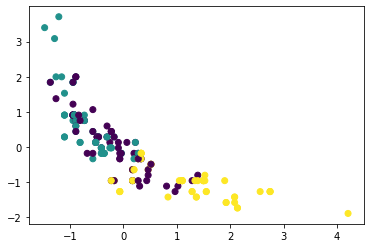

In [22]:
# Gráfico com o resultados dos clusters criados
plt.cla()
plt.scatter(predPd[3], predPd[4], c = predPd[0])